In [1]:
%load_ext autoreload
%autoreload 2

from other_utils import np_utils, sk_utils
import numpy as np
import tensorflow as tf
import os
import numpy as np
import tensorflow as tf
import imageio
from termcolor import colored

import model 
from hyperparams import Hyperparameters
import graph 
from data_loader import Data_loader
import model_componets as comps
from sklearn.decomposition import PCA



utils.py:41: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/virtual_envs/ani_python2.7/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/virtual_envs/ani_python2.7/local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/virtual_envs/ani_python2.7/local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/virtual_envs/ani_python

In [2]:
H = Hyperparameters ()

D = Data_loader(H.data_path,H.seq_length,H.batch_size)


os.environ['CUDA_VISIBLE_DEVICES'] = str(3)

config = tf.ConfigProto()

config.gpu_options.allow_growth = True

sess = tf.InteractiveSession(config=config)


input_ph = tf.placeholder(tf.float32, shape= [None , H.num_joints ,3],name = 'skeleton_input')

global_step = tf.train.get_or_create_global_step()

x_input = input_ph

x_input_view_norm,x_input_local,tr_mats = comps.root_relative_to_local(x_input)

encoder_out = graph.apply_pose_encoder(input_ph)

encoder_input = tf.reshape(encoder_out,(-1,H.seq_length,32))

encoder_lstm_out = model.apply_encoder(encoder_input,name ='motion_encoder')

z_state = encoder_lstm_out['z_state']

z_outputs = encoder_lstm_out['z_outputs']


decoder_lstm_out = model.apply_decoder(z_state,z_outputs,name = 'motion_decoder')

motion_recon = decoder_lstm_out['x_recon']

motion_recon_reshaped = tf.reshape(motion_recon,((-1,32)))

pose_recon = graph.apply_pose_decoder(motion_recon_reshaped)#view norm

pose_encoder_params = graph.get_network_params("Encoder_net")

pose_decoder_params = graph.get_network_params("Decoder_net")

param_lstm_encoder = model.get_network_params('motion_encoder')

param_lstm_decoder = model.get_network_params('motion_decoder')




# sess.run(tf.global_variables_initializer())

print colored("loading weights","blue")

tf.train.Saver(pose_encoder_params).restore(sess,'../../../pose_embedding_train_full_view_norm_range_one/ent44_15j_32/weights/encoder_iter-799001') 
print colored("loaded pose_encoder weights","yellow")
'../../../'

tf.train.Saver(pose_decoder_params).restore(sess,'../../../pose_embedding_train_full_view_norm_range_one/ent44_15j_32/weights/decoder_iter-799001')
print colored("loaded pose_decoder weights","blue")

tf.train.Saver(param_lstm_encoder).restore(sess,tf.train.latest_checkpoint('../../../motion_embedding_train/ent_44_15j_32/BILSTM_TRAIN/weights/lstm_encoder/'))
print colored("loaded pose lstm_encoder weights","green")

tf.train.Saver(param_lstm_decoder).restore(sess,tf.train.latest_checkpoint('../../../motion_embedding_train/ent_44_15j_32/BILSTM_TRAIN/weights/lstm_decoder/'))
print colored("loaded pose lstm_decoder weights","red")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
loading weights
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../../../pose_embedding_train_full_view_norm_range_one/ent44_15j_32/weights/encoder_iter-799001
loaded pose_encoder weights
INFO:tensorflow:Restoring pa

In [3]:
train_batch = np.asarray(D.get_sequence_batch_train())

train_batch = train_batch[:,0:30]

train_batch = train_batch.reshape((-1,H.num_joints , 3))

print train_batch.shape


(1920, 15, 3)


In [4]:
feed_dict = {x_input : train_batch}

pred_ops = sess.run(z_state,feed_dict=feed_dict)
predictions = pred_ops

predictions.shape
print predictions

[[-1.0014939  -1.5246766  -0.19028305 ...  0.17049702 -0.4742871
  -0.7668483 ]
 [-0.09527376 -1.1535432   0.3384257  ... -0.07272644  1.1717038
   0.44312134]
 [-1.6687384   0.49780545  0.7301599  ... -0.5161709  -1.2737913
   0.1570092 ]
 ...
 [-0.656301   -0.74768865  0.3877386  ...  0.16367121 -0.10022261
   0.94214225]
 [-1.3313732  -0.39331383  0.20171991 ...  0.4216869  -0.31458688
  -0.37534964]
 [-1.6684293   0.17221197  0.11312097 ...  0.46376663  0.457709
  -0.66998863]]


In [5]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification

pca = PCA(n_components=2)
X_transformed = pca.fit_transform(predictions)
print X_transformed.shape

data_reduced = np.dot(predictions - pca.mean_, pca.components_.T)
data_original = np.dot(data_reduced, pca.components_) + pca.mean_

print data_original.shape


component1 = X_transformed[:,0]
component2 = X_transformed[:,1]

std1 = np.std(component1)
std2 = np.std(component2)
mean1 = np.mean(component1)
mean2 = np.mean(component2)

no = 4

map_d = 45
std1_dist = np.linspace(mean1 - no *std1,mean1 + no *std1 , map_d)

std1_dist_e = np.expand_dims(std1_dist,axis =1)

std2_dist = np.linspace(mean2 - no *std2,mean2 + no *std2 ,map_d)
std2_dist_e = np.expand_dims(std2_dist,axis =1)

arr = np.empty((map_d,map_d,2))

for i in  range(map_d):
    for j in range(map_d):
        k1 = std1_dist_e[i]
        k2 = std2_dist_e[j]
        k_con = np.concatenate([k1,k2],axis = -1)
    
        arr[i][j]=k_con

print arr.shape 
reshaped = arr.reshape((map_d*map_d,2))

data_original = np.dot(reshaped, pca.components_) + pca.mean_
# mean_proj  = np.dot(np.zeros((100,2)),pca.components_)+pca.mean_

# print mean_proj.shape
# print data_original.shape
# mean_o  = np.mean(data_original,axis = 0)

# print np.mean(np.abs(mean_o - pca.mean_))
# print data_reduced.shape
# print X_transformed.shape

(64, 2)
(64, 128)
(45, 45, 2)


In [6]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# print component1.shape
# plt.hist(component1, bins=30)
# print np.mean(component1)
# plt.ylabel('frequency');
# plt.xlabel('motion embedding value');

In [7]:
# plt.hist(component2, bins=10)

# print np.mean(component2)
# plt.ylabel('frequency');
# plt.xlabel('motion embedding value');

In [8]:
mean = np.mean(predictions, axis=0)
std = np.std(predictions,axis=0)

print mean.shape
print std.shape

print('minimum vaue of mean ', min(mean))
print('minimum value of std ', min(std))
print('maximum value of mean', max(mean))
print('maximum value of std', max(std))


(128,)
(128,)
('minimum vaue of mean ', -1.0693058)
('minimum value of std ', 0.3613297)
('maximum value of mean', 0.87615544)
('maximum value of std', 1.5714966)


In [9]:
sample_1 = mean+(no*std)
sample_2 = mean-(no*std)
sample_1 = np.reshape(sample_1 , (1,128))
sample_2 = np.reshape(sample_2 , (1,128))


In [10]:
a = np.linspace(0,1, map_d)
a = np.reshape(a, (map_d,1))


In [11]:
vertical = a*sample_1[:,:64] + (1-a)*sample_2[:,:64]

assert (vertical[0] == sample_2[0,:64]).all()

print vertical.shape

(45, 64)


In [12]:
horizontal = a*sample_1[:,64:] + (1-a)*sample_2[:,64:]

assert (horizontal[0] == sample_2[0,64:]).all()

print horizontal.shape

(45, 64)


In [13]:
grid = np.empty((map_d,map_d,128))

In [14]:
for i in range(map_d):
    for j in range(map_d):
        grid[i,j] = np.concatenate((vertical[i], horizontal[j]))

In [15]:
grid_flat = np.reshape(grid, (-1,128))

print grid.shape
print grid_flat.shape

(45, 45, 128)
(2025, 128)


In [16]:

state_ph = tf.placeholder(tf.float32,shape = [None,128],name = "lstm_state")

z_outs = tf.stack([state_ph]*H.seq_length, 1)


def decoder(z_state,z_outputs):
    decoder_lstm_out = model.apply_decoder(z_state,z_outputs,name = 'motion_decoder')

    motion_recon = decoder_lstm_out['x_recon']

    motion_recon_reshaped = tf.reshape(motion_recon,((-1,32)))

    pose_recon = graph.apply_pose_decoder(motion_recon_reshaped)#view norm

    pose_decoder_params = graph.get_network_params("Decoder_net")
    
    return pose_recon
    
print colored("loading weights","blue")

tf.train.Saver(pose_encoder_params).restore(sess,'../../../pose_embedding_train_full_view_norm_range_one/ent44_15j_32/weights/encoder_iter-799001') 
print colored("loaded pose_encoder weights","yellow")

tf.train.Saver(pose_decoder_params).restore(sess,'../../../pose_embedding_train_full_view_norm_range_one/ent44_15j_32/weights/decoder_iter-799001')
print colored("loaded pose_decoder weights","blue")

tf.train.Saver(param_lstm_encoder).restore(sess,tf.train.latest_checkpoint('../../../motion_embedding_train/ent_44_15j_32/BILSTM_TRAIN/weights/lstm_encoder/'))
print colored("loaded pose lstm_encoder weights","green")

tf.train.Saver(param_lstm_decoder).restore(sess,tf.train.latest_checkpoint('../../../motion_embedding_train/ent_44_15j_32/BILSTM_TRAIN/weights/lstm_decoder/'))
print colored("loaded pose lstm_decoder weights","red")
 
pred_ops_ph = decoder(state_ph,z_outs)

pred_ops = sess.run(pred_ops_ph,feed_dict={state_ph : grid_flat})
    
predictions = pred_ops.reshape(-1,H.seq_length,H.num_joints,3)

pred_ops_new = sess.run(pred_ops_ph,feed_dict={state_ph : data_original})
    
predictions_new = pred_ops_new.reshape(-1,H.seq_length,H.num_joints,3)


loading weights
INFO:tensorflow:Restoring parameters from ../../../pose_embedding_train_full_view_norm_range_one/ent44_15j_32/weights/encoder_iter-799001
loaded pose_encoder weights
INFO:tensorflow:Restoring parameters from ../../../pose_embedding_train_full_view_norm_range_one/ent44_15j_32/weights/decoder_iter-799001
loaded pose_decoder weights
INFO:tensorflow:Restoring parameters from ../../../motion_embedding_train/ent_44_15j_32/BILSTM_TRAIN/weights/lstm_encoder/rule_based_motion_net_expt_seq305400
loaded pose lstm_encoder weights
INFO:tensorflow:Restoring parameters from ../../../motion_embedding_train/ent_44_15j_32/BILSTM_TRAIN/weights/lstm_decoder/rule_based_motion_net_expt_seq305400
loaded pose lstm_decoder weights


In [17]:
print predictions.shape
print predictions_new.shape


(2025, 30, 15, 3)
(2025, 30, 15, 3)


In [18]:
predictions = np.mean(predictions, axis=(-1,-2))
predictions_new = np.mean(predictions_new,axis=(-1,-2))
print predictions.shape
# print predictions_new.shape

(2025, 30)


In [19]:
velocity = predictions[:,1:] - predictions[:,:-1]

speed = np.absolute(velocity)

velocity_new = predictions_new[:,1:] - predictions_new[:,:-1]

speed_new = np.absolute(velocity_new)


print(speed.shape)
# print(speed_new.shape)

(2025, 29)


In [20]:

speed  = np.mean(speed, axis=-1)

speed = np.reshape(speed, (map_d,map_d))


speed_new  = np.mean(speed_new, axis=-1)

speed_new = np.reshape(speed_new, (map_d,map_d))

# print speed_new.shape


In [21]:

def make_big_arr(speed):
    big_speed = []
    bigger_speed = []
    no_inters = 5

    for i in range(speed.shape[0]-1):
        j = i + 1
        c = np.array([np.linspace(a,b,no_inters + 2) for a,b in zip(speed[i],speed[j])]).T

        if i == 0:
            for k in range(c.shape[0]):
                big_speed.append(c[k])
        else :
            for l in range(c.shape[0]):
                if l == 0 :
                    continue
                else :
                    big_speed.append(c[l])


    print np.array(big_speed).shape


    for u in range(np.array(big_speed).shape[0]):
        k = big_speed[u]
        new_arr = []
        for i in range(len(k)-1):
            j= i +1
            interp = np.linspace(k[i],k[j],no_inters + 2)
            if i == 0 :
                for ele in interp:
                    new_arr.append(ele)
            else :
                for m in range(len(interp)):
                    if m ==0 : 
                        continue
                    else :
                        new_arr.append(interp[m])

        bigger_speed.append(new_arr)
    return bigger_speed
    
# print speed[i]
# print speed[j]
# print c


In [22]:
import matplotlib.pyplot as plt
%matplotlib inline  

(265, 45)
(265, 45)


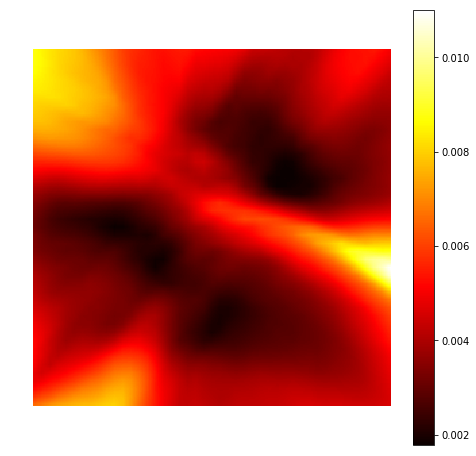

In [23]:
# # import matplotlib
# plt.imshow(speed, cmap='hot', interpolation='nearest')
# plt.colorbar()

# # plt.savefig("test.png",bbox_inches = 'tight',dpi=350);


# plt.show()

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(1,1,1)
first = ax1.imshow(make_big_arr(speed), cmap='hot', interpolation='nearest')
plt.colorbar(first,ax = ax1)
plt.axis('off')
plt.savefig("./sigma"+str(no)+"_without_pca.png",bbox_inches = 'tight',dpi = 350);
plt.close()

fig2 = plt.figure(figsize=(8,8))
ax2 = fig2.add_subplot(1,1,1)
second = ax2.imshow(make_big_arr(speed_new), cmap='hot', interpolation='nearest')
plt.colorbar(second,ax = ax2)
plt.axis('off')
plt.savefig("./sigma"+str(no)+"_with_pca.png",bbox_inches = 'tight',dpi = 350);


plt.show()




In [24]:
# fig = plt.figure()

# ax2 = fig.add_subplot(1,1,1)

# second = ax2.imshow(speed_new, cmap='hot', interpolation='nearest')
# plt.colorbar(second,ax = ax2)
# plt.axis('off')
# plt.savefig("./sigma"+str(no)+"_with_pca.png",bbox_inches = 'tight',dpi = 350);

# plt.show()
